<h1><center>An interesting project</center></h1>

---

<h3><center> Analysing the Hatnote websocket messages </center></h3>

<h3><center> We begin by some preamble of our analysis </center></h3>

<h3> <center> The Hatnote websocket url </center> </h3>

In [1]:
url = "ws://wikimon.hatnote.com:9000"

---

<h3><center> We import the modules that we need </center></h3>

In [2]:
# the following are the imports from the current
# directory which I created to abstract away the
# complecated logic

from hatnote_websocket import subscribers, publishers

<h3><center> We initialise our subscribers </center></h3>

In [3]:
title_analysers = [subscribers.TitleSubscriber() for _ in range(10)]
hit_analysers = [subscribers.HitSubscriber() for _ in range(10)]
change_size_analysers = [subscribers.ChangeSizeSubscriber() for _ in range(10)]

analysers = [[ta, ha, csa] for (ta, ha, csa) in zip(title_analysers, hit_analysers, change_size_analysers)]

<center> These subscribers will be the data analysers which satisfy a simple protocol (interface) </center>

<center> There may infact be a better way to initialise them for 10 independent analysis on the 10 different datasets but I couldn't think of a better way. </center>

<h3> <center> Our analysis </center> </h3>

<h3> <center> We create a result to hold all the results of independent analysis' </center> </h3>

In [4]:
result = {
    "title_analyser_results": [],
    "hit_analyser_results": [],
    "change_size_analyser_results": [],
}

<h3> <center> We then loop over all the analysers set to and pass it to our publisher </center> </h3> 

In [5]:
for analyser in analysers:
    publisher = publishers.Publisher(url, analyser, 100)
    await publisher.publish()
    result["title_analyser_results"].append(analyser[0].result())
    result["hit_analyser_results"].append(analyser[1].result())
    result["change_size_analyser_results"].append(analyser[2].result())

<center> Our publisher is essentially consuming the message from the websocket and broadcasting it to all our analysers </center>

<center> The idea follows a very simple <i> Publisher-Subscriber </i> pattern but since the publisher itself a subscriber to the websocket, we can consider it somewhat a hybrid of this pattern </center>

<h3> <center> Now we extract the analyser result samples from the result dictionary </center> </h3>

In [6]:
title_analyser_results = result.get("title_analyser_results")
hit_analyser_results = result.get("hit_analyser_results")
change_size_analyser_results = result.get("change_size_analyser_results")

<h3> <center> We use our <i> Title Analyser </i> in an interesting way </center> </h3>

<center> <b>Hypothesis:</b> On average, there are at least 2.5 webpages being edited more than once. </center>

<center> This can mean a number of things, but our focus will be considering the possibility of mistakenly commiting the edit and realising they made a mistake </center>

<center> <b> Note: </b> this is not very scientific, hence we will not be doing hypothesis testing. </center>

In [7]:
title_edits_more_than_once = []

for analysis in title_analyser_results:
    edits_greater_than_one = sum(times for _, times in analysis.items() if times > 1)
    title_edits_more_than_once.append(edits_greater_than_one)

In [8]:
from matplotlib import pyplot
%matplotlib inline 
pyplot.rcParams["figure.figsize"] = [12.00, 5.00]
pyplot.rcParams["figure.autolayout"] = True

<BarContainer object of 10 artists>

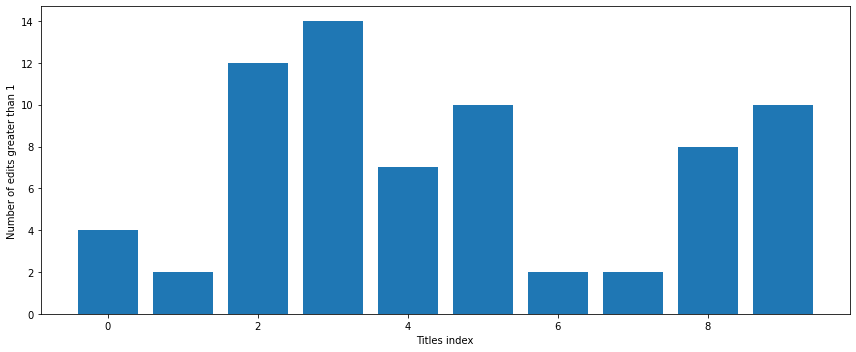

In [9]:
pyplot.xlabel("Titles index")
pyplot.ylabel("Number of edits greater than 1")
pyplot.bar(list(range(len(title_edits_more_than_once))), title_edits_more_than_once)

In [10]:
def average(data: list[int]) -> float:
    """Get the average of our data set."""
    return sum(data) / len(data)

<h3> <center> And so our average is </center> </h3>

In [11]:
average_title_edits = average(title_edits_more_than_once)

In [12]:
average_title_edits

7.1

<center> Of course, this is a small sample and taken consecutively so it doesn't really tell us much about its validity. So whether this is significant result or not is also not answered here as this would be a complete task on its own. But it is interesting to think about this question, since in the context of code and programming this could mean an incorrect commit that could be pushed to source control and result in breaking environments without thorough code reviews. </center>

<h3> <center> Using our <i> Hit Analyser </i> </center> </h3>

<center> The purpose of Hit analyser is only to see on average how many users get an abuse filter and blocks that happen every hundred messages from the websocket. </center> 

In [13]:
num_of_hits = [len(res) for res in hit_analyser_results]

average_hits = average(num_of_hits)

<h3> <center> When plotting our result, we can see that our result looks something like this </center> </h3>

<BarContainer object of 10 artists>

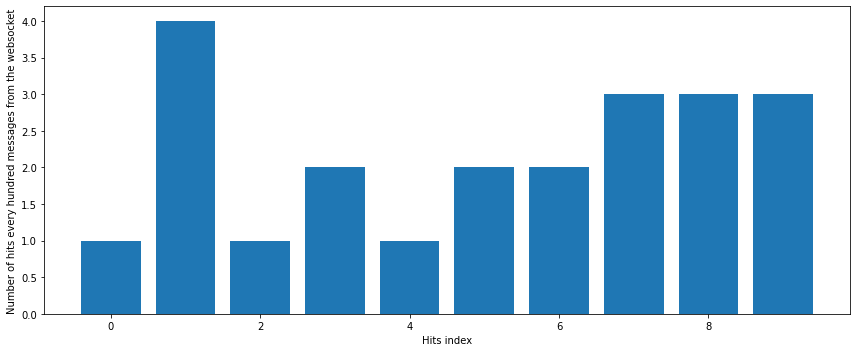

In [14]:
pyplot.xlabel("Hits index")
pyplot.ylabel("Number of hits every hundred messages from the websocket")
pyplot.bar(list(range(len(num_of_hits))), num_of_hits)

<h3> <center> So our average number of hits is </center> </h3>

In [15]:
average_hits

2.2

<h3> <center> The idea for the Change Size Analyser was to see how much data changes for each title that gets edited over a hundred messages received from the Websocket </center> </h3>

In [16]:
def calculate_size_delta(result_dict):
    return sum(size for _, size in result_dict.items())

<h3> <center> This is what our data set looks like </center> </h3>

In [17]:
total_deltas_over_samples = [calculate_size_delta(res) for res in change_size_analyser_results]

<BarContainer object of 10 artists>

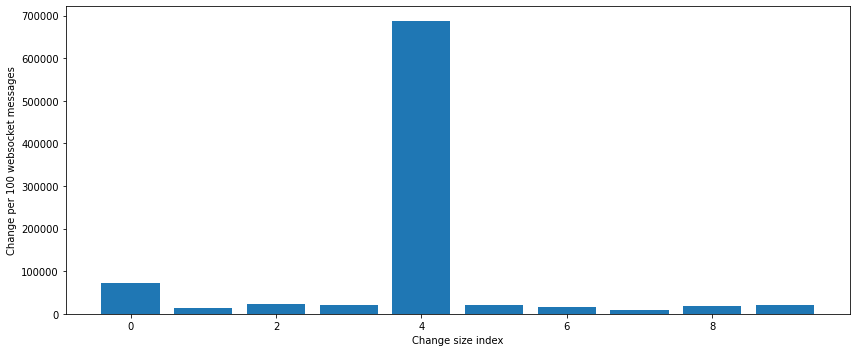

In [19]:
pyplot.xlabel("Change size index")
pyplot.ylabel("Change per 100 websocket messages")
pyplot.bar(list(range(len(total_deltas_over_samples))), total_deltas_over_samples)

<h3> <center> We calculate our average number of byte changes in each edit </center> </h3>

<h3> <center> And finally get our average change size </center> </h3>

In [20]:
average_change_in_size = average(total_deltas_over_samples)

In [21]:
average_change_in_size

90395.2

<h3> <center> Explanation of our approach </center> </h3>

<center> This was a very basic analysis of the data that I needed to analyse. So here I want to explain the approach taken when I created the publisher and subsriber pattern. </center>

<h3> <center> The websocket message </center> </h3>

<center> Since we already know what the websocket message looks like, we constructed a simple `pydantic` BaseModel to make it easier to work with. </center>

<h3> <center> Message Base Model </center> </h3>

```python
class Message(pydantic.BaseModel):
    """Schema for the hatnote-websocket response messages."""

    action: str
    change_size: int | None
    flags: str | None
    hashtags: list[str]
    is_anon: bool
    is_bot: bool
    is_minor: bool
    is_new: bool
    is_patrolled: bool | None
    mentions: list[str]
    ns: str
    page_title: str
    parsed_summary: str | None
    section: str
    summary: str | None
    user: str

```

<center> Note that we could have chosen to work with python dataclasses here and not rely on `pydantic` but `pydantic` provides some extra type safety that is not present in dataclasses by default. Thus we chose to use it here. </center>

<h3> <center> Publisher </center> </h3>

<center> Our Publisher class looks like this: </center>

```python

class Publisher:
    """Class which consumes a message from the websocket and broadcasts to subscribers."""

    def __init__(self, url: str, analysers: list[Subscriber], count: int):
        """Initialize the websocket publisher."""
        self._analysers = analysers
        self._url = url
        self.counter = count

    async def publish(self):
        async with websockets.connect(self._url) as ws:
            for _ in range(self.counter):
                event = await ws.recv()
                message = Message.parse_raw(event)
                await asyncio.gather(
                    *[analyser.consume(message) for analyser in self._analysers]
                )
```

This class has only one responsibility, which is to listen for a message to the websocket `url` and broadcast that message to the subscribers.

<h3> <center> Subscribers </center> </h3>

<center> Our subscribers are classes which satisfy is a simple protocol: </center>

```python
class Subsriber(typing.Protocol):
    """Subscriber protocol."""

    async def consume(self, message: Message) -> None:
        """Consume a message from the publisher."""

    def result(self) -> dict[str, int]:
        """The result outputs the processed result of the messages consumed."""

```

<center> We could have chosen to divide this protocols to two different protocols. However, for this project we decided that currently this is not needed since we are not using the result method in any meaningful way. In fact, all the analysis for these results in done in this report which was to demonstrate the simple usecases.</center>  

<h3> <center> Our analysers are classes that simply satisfy this protocol. </center> </h3>

<h3> <center> TitleSubscriber </center> </h3>



```python
class TitleSubscriber:
    """Subscriber class which consumes messages from the publisher."""

    def __init__(self):
        """Initialize the message subscriber."""
        self._titles: dict[str, int] = {}
        self.mutex = Lock()

    async def consume(self, message: Message) -> None:
        """Consume a message from the publisher."""
        if message.action == "edit":
            if self._titles.get(message.page_title) is None:
                with self.mutex:
                    self._titles[message.page_title] = 1
                return
            with self.mutex:
                self._titles[message.page_title] += 1

    def result(self) -> dict[str, int]:
        """Return the result of the analysis."""
        return self._titles

```

<h3> <center> HitSubscriber </center> </h3>

```python
class HitSubscriber:
    """Subscriber class which consumes messages from the publisher."""

    def __init__(self):
        """Initialize the hit subscriber."""
        self._titles: dict[str, int] = {}
        self.mutex = Lock()

    async def consume(self, message: Message) -> None:
        """Consume a message from the publisher."""
        if message.action == "hit":
            with self.mutex:
                self._titles[f"{message.page_title}-{message.user}"] = 0

    def result(self) -> dict[str, int]:
        """Return the number of hits."""
        return self._titles

```

<h3> <center> ChangeSizeSubscriber </center> </h3>

```python
class ChangeSizeSubscriber:
    """Subscriber class which consumes messages from the publisher."""

    def __init__(self):
        """Initialize the change size subscriber."""
        self._titles: dict[str, int] = {}
        self.mutex = Lock()

    async def consume(self, message: Message) -> None:
        """Consume a message from the publisher."""
        if message.action == "edit":
            if self._titles.get(message.page_title) is None:
                with self.mutex:
                    self._titles[message.page_title] = abs(message.change_size)
                return
            with self.mutex:
                self._titles[message.page_title] += abs(message.change_size)

    def result(self) -> dict[str, int]:
        """Return the result of the analysis."""
        return self._titles

```

<center> Further note that these classes are all using a mutex, which makes these threadsafe and prevent race conditions in the asynchronous `publish` method of our `Publisher` class. </center>

<h3> <center> Conclusion </center> </h3>

<center> In this small report, we have seen that: </center>

1. For every hundred messages that we receive from the websocket there are on average 7.1 times where a single page is edited more than once (out of 10 samples;)

2. For every hundred messages that we receive from the websocket, there are on average 2.2 number of abuse filters (out of 10 samples;)

3. For every hundred messages that we receive from the websocket, the byte changes on wikipedia server has an average of 90395.2 (out of 10 samples.)